In [1]:
import os
import sys
import numpy as np
import warnings
import pandas as pd
import matplotlib
from scipy import special
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

root_path = root_path = os.path.realpath('../..')
try:
    import auto_causality
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "auto-causality"))

from auto_causality import AutoCausality
from auto_causality.data_utils import preprocess_dataset

warnings.filterwarnings("ignore")

2022-09-29 06:55:10.437725: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/opt/conda/envs/bm_prep/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def iv_dgp_econml(n=5000, p=10, true_effect=10):

    X = np.random.normal(0, 1, size=(n, p))
    Z = np.random.binomial(1, 0.5, size=(n,))
    nu = np.random.uniform(0, 5, size=(n,))
    coef_Z = 0.8
    C = np.random.binomial(
        1, coef_Z * special.expit(0.4 * X[:, 0] + nu)
    )  # Compliers when recomended
    C0 = np.random.binomial(
        1, 0.006 * np.ones(X.shape[0])
    )  # Non-compliers when not recommended
    T = C * Z + C0 * (1 - Z)
    y = (
            true_effect(X) * T
            + 2 * nu
            + 5 * (X[:, 3] > 0)
            + 0.8 * np.random.uniform(0, 1, size=(n,))
    )
    cov = [f"x{i}" for i in range(1, X.shape[1] + 1)]
    df = pd.DataFrame(X, columns=cov)

    df["y"] = y
    df["treatment"] = T
    df["Z"] = Z

    return df

In [3]:
# Dataset parameters
treatment = "treatment"
targets = ["y"]
instruments = ["Z"]
outcome = targets[0]

In [4]:
TRUE_EFFECT = 5.5

# LINEAR_EFFECT = lambda X: TRUE_EFFECT
LINEAR_EFFECT = lambda X: TRUE_EFFECT  * ((X[:, 0] ** 2) * X[:, 1])
# LINEAR_EFFECT = lambda X: TRUE_EFFECT * ((X[:, 0] ** 2) * X[:, 1])

synth_data = iv_dgp_econml(n=40000, p=15, true_effect=LINEAR_EFFECT)
data_df, features_X, features_W = preprocess_dataset(
    synth_data, treatment, targets, instruments
)
df_train, df_test = train_test_split(data_df, test_size=0.2)

X_test = df_test[features_X[:2]]
df_train.head()

,treatment,y,Z,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,random
15098,1.0,12.779978,1.0,-1.696384,0.310897,-0.210462,-1.284096,-0.676640,0.476552,-0.315704,1.670150,-0.954829,0.662490,2.230885,-0.044379,0.880486,0.046840,1.454443,1.0
14064,0.0,14.334971,0.0,1.665999,0.554807,-0.589626,0.697823,1.612239,0.008868,-2.422107,0.818334,-2.790208,-0.812864,0.850895,-0.907066,1.303823,2.615109,1.517147,1.0
25332,1.0,8.174202,1.0,-0.244119,0.453921,0.258049,-0.681035,-0.285913,-0.194744,-0.619259,-1.831603,0.506908,0.453135,-0.324344,-0.732982,-1.564473,-1.330014,0.503287,0.0
36374,1.0,-2.304624,1.0,-1.151727,-1.197196,-0.359492,-0.246688,0.175394,-0.256952,0.400856,-0.208744,0.316365,0.698880,0.108891,0.142555,-0.018531,-0.787962,1.173006,1.0
37298,1.0,6.703805,1.0,-0.442796,1.356343,-1.051542,0.633314,1.298684,-1.157566,-0.277695,-1.982441,0.747646,0.768029,-0.221478,0.088614,-2.002008,1.299187,1.304093,0.0


In [12]:
estimator_list = ["SimpleIV", "DMLIV", "ForestDRIV", "IntentToTreatDRIV"]

In [5]:
ac_linear_te = AutoCausality(
    estimator_list=["SimpleIV", "ForestDRIV"],
    verbose=3,
    components_verbose=2,
    time_budget=14400,
    components_time_budget=200,
    propensity_model="auto"
)

ac_linear_te.fit(df_train, treatment, outcome, features_X[2:], features_X[:2], instruments)

Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks


[flaml.tune.tune: 09-29 06:59:55] {376} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 09-29 06:59:55] {506} INFO - trial 1 config: {'estimator': {'estimator_name': 'iv.auto_causality.models.SimpleIV'}}


Initial configs: [{'estimator': {'estimator_name': 'iv.auto_causality.models.SimpleIV'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.ForestDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1, 'min_samples_split': 2}}]


2022-09-29 07:00:12.725400: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
[flaml.tune.tune: 09-29 07:00:24] {118} INFO - result: {'energy_distance': 0.15924847784734109, 'estimator_name': 'iv.auto_causality.models.SimpleIV', 'scores': {'train': {'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x7fa07423ca50>, 'ate': -0.2255582958459854, 'ate_std': 0.0, 'energy_distance': 0.141109613616055}, 'validation': {'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x7fa0742644d0>, 'ate': -0.2255582958459854, 'ate_std': 0.0, 'energy_distance': 0.15924847784734109}}, 'config': {'estimator': {'estimator_name': 'iv.auto_causality.models.SimpleIV'}}, 'training_iteration': 0, 'config/estimator': {'estimator_name': 'iv.auto_causality.models.SimpleIV'}, 'experiment_tag': 'exp', 'time_total_s': 28.90767240524292}
[flaml.tune.tune: 09-29 07:00:24] {506} INFO - trial

In [6]:
len(ac_linear_te.results.results)

In [36]:
# Single Estimator evaluation
def mse_causal_effect(estimator, test, y_effect):
    est_effect = estimator.effect(test)
    mse = np.square(est_effect - y_effect).mean()
    return mse

def evaluate_estimator(estimator, test_cov, test_df, y_effect, ac_model):
    mse_score = mse_causal_effect(estimator.estimator, test_cov, y_effect)
    energy_distance = ac_model.scorer.make_scores(
                    estimator,
                    test_df,
                    problem=ac_model.problem,
                    metrics_to_report=["energy_distance"]
                )["energy_distance"]
    return [mse_score, energy_distance]

In [22]:
Xtest = df_test[features_X[:2]]
CATE_VALUES = lambda x, y: TRUE_EFFECT * (x ** 2) * y

cate_y = CATE_VALUES(Xtest.values[:, 0], Xtest.values[:, 1])

In [27]:
results = list()
trial_no = 1
for key, trials in ac_linear_te.results.results.items():
    est_name = trials["estimator_name"]
    if est_name == "iv.econml.iv.dr.ForestDRIV":
        if "estimator" in trials:
            causal_estimator = trials["estimator"]
            mse_score = mse_causal_effect(causal_estimator.estimator, Xtest, cate_y)
            energy_distance = ac_linear_te.scorer.make_scores(
                    causal_estimator,
                    df_test,
                    problem=ac_linear_te.problem,
                    metrics_to_report=ac_linear_te.metrics_to_report
                )["energy_distance"]
            results.append([key, trial_no, mse_score, energy_distance])
        trial_no += 1

df_results = pd.DataFrame(results, columns=["key", "iter", "mse", "energy"])
df_results

,key,iter,mse,energy
0,0a6a633c,3,24.408989,0.016853
1,b4bab6dc,5,28.485951,0.021492
2,86eacc16,6,23.744893,0.016627
3,60594c18,7,25.842187,0.017606
4,2dc8c086,8,24.705313,0.016595
5,fba2e0ce,9,25.451310,0.017156


In [73]:
import pickle

with open("forestdriv.pkl", "wb") as f:
    pickle.dump(df_results, f)

In [37]:

best_estimator = ac_linear_te.scores["iv.econml.iv.dr.ForestDRIV"]["estimator"]
scores = evaluate_estimator(best_estimator, Xtest, df_test, cate_y, ac_linear_te)
scores

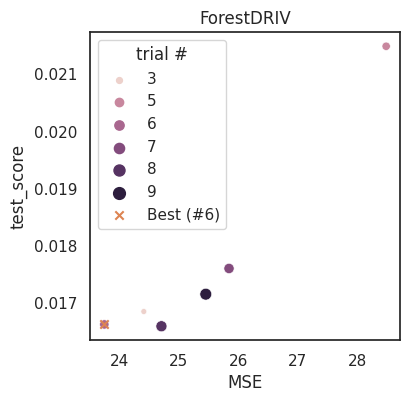

In [76]:
%matplotlib inline

import seaborn as sns

sns.set(font_scale=1)
sns.set_theme(style='white')

fig, ax = plt.subplots(figsize=(4, 4))

g = sns.scatterplot(
    df_results,
    x = "mse",
    y = "energy",
    hue="iter",
    size="iter",
    legend="full",
    ax=ax
)

g.set(
    xlabel="MSE",
    ylabel="test_score",
    title="ForestDRIV"
)


n_iter = df_results[
    (df_results.mse == scores[0]) &
    (df_results.energy == scores[1])
]["iter"].values[0]

ax.scatter(scores[0], scores[1], marker="x", label=f"Best (#{n_iter})", )
ax.legend()
g.legend(title="Trial #")
plt.show()